# Create test dataframe

In [4]:
import numpy as np
import pandas as pd
from time import sleep
from os import environ
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signal_stat.signal_stat import SignalStat
from indicators.indicators import IndicatorFactory

debug = True
# Set environment variable
environ["ENV"] = "development"
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'Binance': {'BTCUSDT': ['5m']}}
# Get configs
configs = ConfigFactory.factory(environ).configs

    
for exchange in exchanges:
    exchange_api = DataFactory.factory(exchange)
    tickers = exchanges[exchange]
    for ticker in tickers:
        timeframes = tickers[ticker]
        for timeframe in timeframes:
            print(f'Exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            # # If all cryptocurrencies signal stat is in dataframe dict - get it, else create new
            # stat = dfs.get('stat', pd.DataFrame())
            # If cryptocurrency dataframe and it's signal stat is in dataframe dict - get it,
            # else - create the new ones
            df = dfs.get(ticker, dict()).get(timeframe, pd.DataFrame())
            # If dataframe is empty - get all available data to fill it,
            # else - just get necessary for update data
            if df.shape == (0, 0):
                interval = configs['Interval']['creation_interval']
            else:
                interval = configs['Interval']['update_interval']
            # Write data to the dataframe
            if debug:
                df = pd.read_pickle('debug.pkl')
            else:
                df = exchange_api.get_data(df, ticker, timeframe, interval)
            # Create indicator list
            indicator_list = configs['Indicator_list']
            indicators = list()
            for indicator in indicator_list:
                indicators.append(IndicatorFactory.factory(indicator, configs))
            # Write indicators to dataframe
            df = exchange_api.add_indicator_data(df, indicators, ticker, timeframe)
            # Update dataframe dict
            if ticker not in dfs:
                dfs[ticker] = dict()
            dfs[ticker][timeframe] = df
            # Get signal
            fs = FindSignal(configs)
            points = fs.find_signal(df)
            # Write statistics
            ss = SignalStat()
            dfs = ss.write_stat(dfs, ticker, timeframe, points)
            ss.calculate_total_stat(dfs, 'buy')

Exchange is Binance, ticker is BTCUSDT, timeframe is 5m


In [61]:
class SupResFinder:
    """ Find support and resistance levels """
    @staticmethod
    def is_support(df: pd.DataFrame, i):
        support = df['low'][i] < df['low'][i-1] and df['low'][i] < df['low'][i+1] < df['low'][i+2] and \
                  df['low'][i-1] < df['low'][i-2]
        return support

    @staticmethod
    def is_resistance(df, i):
        resistance = df['high'][i] > df['high'][i-1] and df['high'][i] > df['high'][i+1] \
                     and df['high'][i+1] > df['high'][i+2] and df['high'][i-1] > df['high'][i-2]

        return resistance

    def find_levels(self, df):
        levels = list()
        s = np.mean(df['high'] - df['low']) * 2

        for index, row in df.iterrows():
            if 2 <= index <= df.shape[0] - 2:
                if self.is_support(df, index):
                    level = row['low']

                    if np.sum([abs(level - x[0]) < s for x in levels]) == 0:
                        levels.append((level, 'sup'))

                elif self.is_resistance(df, index):
                    level = row['high']

                    if np.sum([abs(level - x[0]) < s for x in levels]) == 0:
                        levels.append((level, 'res'))

        return levels
            
                    
srf = SupResFinder()
levels = srf.find_levels(df)
len(levels)

17

## Plot STOCH values

(83, 'buy')


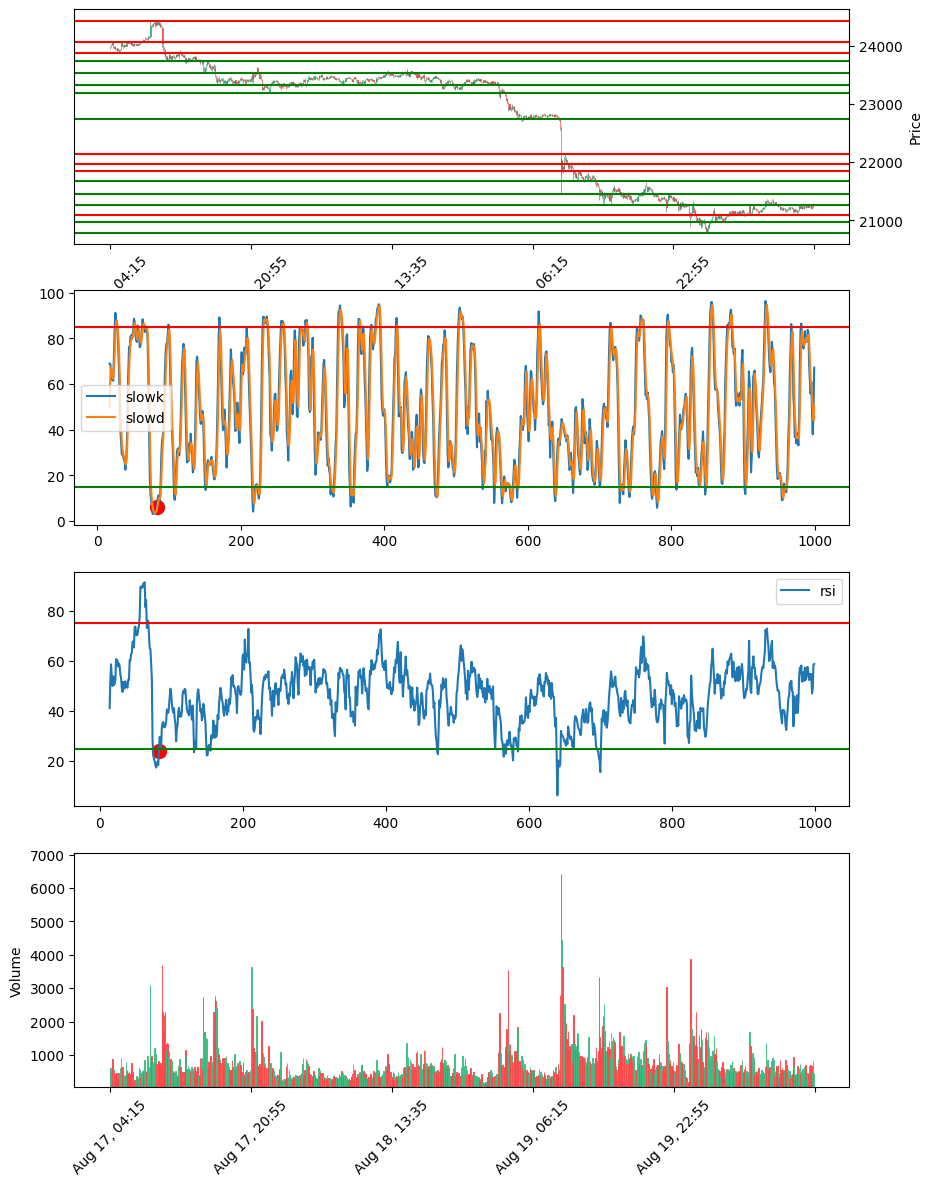

In [62]:
from os import environ
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from config.config import ConfigFactory
from signals.find_signal import FindSignal

pd.set_option('display.max_rows', 500)

# Set environment variable
environ["ENV"] = "development"

configs = ConfigFactory.factory(environ).configs
df = pd.read_pickle('df.pkl')
fs = FindSignal(configs)
points = fs.find_signal(df)

# save signal points for visualization
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    print(point)
    scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
    scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))
    
# subplots for STOCH and RSI
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 14))

# plot candles
ohlc = df.loc[:, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo', volume=ax4)

# plot STOCH
ax2.plot(df.loc[:, 'stoch_slowk'])
ax2.plot(df.loc[:, 'stoch_slowd'])
# show bounders
ax2.axhline(y=15, color='g', linestyle='-')
ax2.axhline(y=85, color='r', linestyle='-')
leg = ax2.legend(['slowk', 'slowd'])

for point in scatter_stoch_points:
    ax2.scatter(point[0], point[1], s=100, color='red')

# plot RSI
ax3.plot(df.loc[:, 'rsi'])
ax3.axhline(y=25, color='g', linestyle='-')
ax3.axhline(y=75, color='r', linestyle='-')
leg = ax3.legend(['rsi'])

for point in scatter_rsi_points:
    ax3.scatter(point[0], point[1], s=100, color='red')

scatter_stoch_points

srf = SupResFinder()
levels = srf.find_levels(df)
for level in levels:
    # show bounders
    if level[1] == 'sup':
        ax1.axhline(y=level[0], color='g', linestyle='-')
    else:
        ax1.axhline(y=level[0], color='r', linestyle='-')

In [46]:
df.loc[80:85]

,time,open,close,high,low,volume,stoch_slowk,stoch_slowd,rsi,stoch_slowk_dir,stoch_slowd_dir,diff
80,2022-08-17 07:55:00,23776.70,23786.42,23827.61,23759.30,1155.77550,3.214664,3.524236,18.372694,-0.130408,-0.220419,-1.233274
81,2022-08-17 08:00:00,23788.32,23795.62,23825.13,23759.40,1385.75486,3.878703,3.611561,19.806587,-0.050920,-0.154573,-0.747301
82,2022-08-17 08:05:00,23795.62,23761.72,23796.62,23735.00,1337.38112,4.429418,3.840928,18.515896,0.090166,-0.077305,-0.006819
83,2022-08-17 08:10:00,23760.76,23796.17,23838.55,23757.04,946.77880,6.229579,4.845900,23.940177,0.129728,0.028031,0.444175
84,2022-08-17 08:15:00,23796.49,23835.14,23873.95,23796.49,1111.45870,9.633316,6.764104,29.645584,0.232115,0.153448,0.959790
85,2022-08-17 08:20:00,23835.14,23788.96,23843.88,23785.05,712.90386,11.149776,9.004224,27.055602,0.291752,0.215391,1.450815


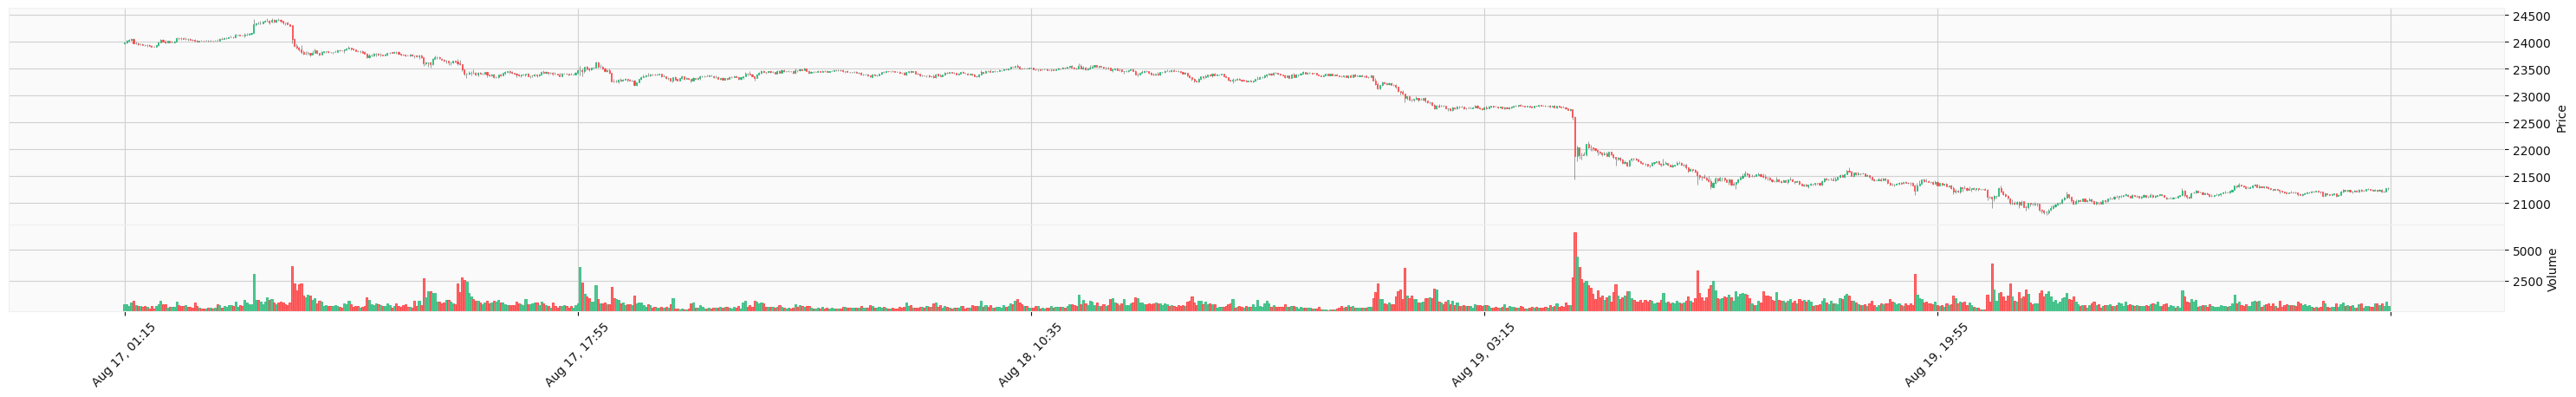

In [32]:


# # Customize market colors, and place inside style you intend to use:
# mc = mpf.make_marketcolors(up='yellow',down='yellow')
# s  = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=mc)

# # # Create an all `nan` values dataframe, same size, and same index as the first:
# # nans = [float('nan')]*len(df)
# # cdf = pd.DataFrame(dict(Open=nans,High=nans,Low=nans,Close=nans),index=df.index)

# # # Copy in the specific candles that you want to color:
# # cdf.loc['2019-11-08'] = df.loc['2019-11-08']
# # cdf.loc['2019-11-15'] = df.loc['2019-11-15']
# # cdf.loc['2019-11-19'] = df.loc['2019-11-19']

# # Call `mpf.plot()` twice with the two dataframes and two styles:
# fig, axlist = mpf.plot(df, type='candle',style='yahoo',returnfig=True)
# mpf.plot(cdf, type='candle', style=s,ax=axlist[0])




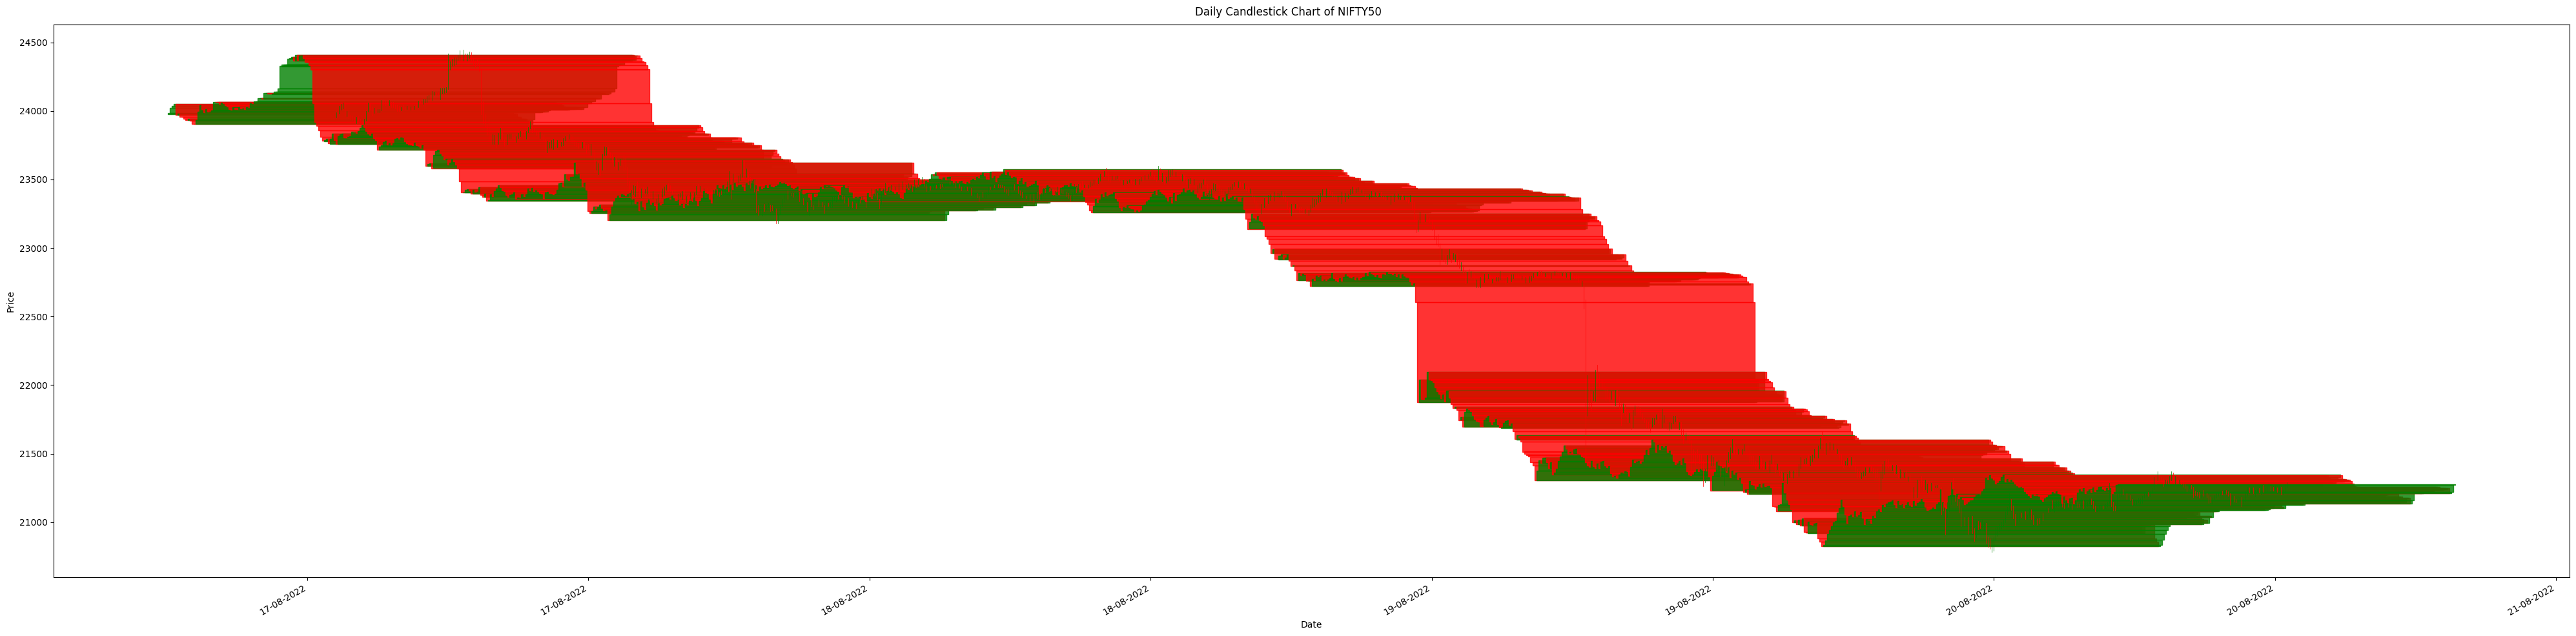

In [25]:

# ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['time'] = ohlc['time'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots(figsize=(40, 10))

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of NIFTY50')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()